$\mathrm{\huge{Gradient\, of \, column\, entasis}}$



$\mathrm{Bernhard \,Fritsch^{1,2}, Malte\,Vogl^{1,3},Björn\,Hansen^{1}}$
  
1: Excellence Cluster 264 Topoi, 2: Berliner Antike Kolleg 
3: Max Planck Institute for History  of Science  
Corresponding mail: bernhard.fritsch@topoi.org  
Date: 01. July 2017

**goal:** The notebook imports the 3D model of a column in xyz format, cuts the pointcloud into slices and calculates the smallest enclosing circle of each slice. The radius of the circles are plotted and thus show the run of the curve of the entasis of the column.
<br>
You can load xyz files (without normals) of columns in the import data cell. z of the xyz-file is the height and is recommanded to be a positive value. It is possible to analyze a single column, or even multiple columns at the same time. In this case, single plots for every columns are visualized, as well as plots with all graphs in one sheet.
<br>
Keywords: ancient columns, entasis
<br>

#   Import data

- Note! In order to change the input values in 1.1, 1.2 and 1.3 go to the top right and toggle on the code

## Import files

file_list and list_of_url  defines the lists of files that will be loaded in.

Urls are entered using the whole url to the column, with quotation marks around the url "http://someurl". The program will then find the file containing the coordinates.
DOIs are added as the number with quotation marks around like this "10.17171/1-1-10" the program will then do the rest.

Example:
```
file_list=['Name of xyz-file']
or
list_of_url=['10.17171/2-2-20-2','10.17171/2-2-25-2','http://repository.edition-topoi.org/collection/CLMN/single/00040']  
```

In [1]:
file_list=[]
list_of_url=['10.17171/2-2-25-2','http://repository.edition-topoi.org/collection/CLMN/single/00106/0']

## Labels

The plot_name gives the plots titles, and should be in the order they appear, first file_list then list_of_url.

Example:

```
plot_name=["filename1", "filename2", "filename3"]

```

In [2]:
plot_name=["Hadrians Library, Athens", "St. Peter, Rome"]

## Variables

Slice range is the value of the distance in which the column is cut into slices in meters.

Save plot defines if the plot should be saved on the server or just visualised, this can be True or False

xmax and xmin defines the minimun value and maximum vale on the xaxis

```
slice_range = 0.01
xmax=0.8 #Max on x-axis
xmin = 0.3
```

In [3]:
slice_range = 0.01
save_plot = True #True  / False
xmax=0.7 #Max on x-axis
xmin = 0.4

##   Import libraries and tools

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as scipy
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import nan
import random
import math
import requests
import urllib
import re
from bs4 import BeautifulSoup

In [5]:
import json

for url_adr in list_of_url:
    if "http" not in  url_adr:
        resTemp = "http://data.datacite.org/"+ url_adr
        url_adr = requests.get(resTemp).url 
        url_adr = re.sub('CitableHandler','collection',url_adr[:-2])
    elif  url_adr[-2]=="/":
        url_adr= url_adr[:-2]    
    url2 = url_adr.replace("collection", "CitableHandler")
    url2+="?getDigitalFormats"
    url = url_adr
    req = urllib.request.Request(
    url , data=None, headers={ 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    })
    url  = urllib.request.urlopen(req)    
    soup = BeautifulSoup(url , "lxml")
    nxs = ""
    temp_list=[]
    for link in soup.findAll("a"):
        #print(link)
        if ".xyz" in link.get("href"):
            temp_list.append(link.get("href"))
        if ".nxs" in link.get("href"):
            nxs = link.get("href").split(".nxs")[0]
            #temp_list.append(nxs)
            base_url=nxs          
    #base="http://"+url_adr.split("/")[2]+"/"+url_adr.split("/")[4]
    print(base_url)
    base_url="http:/"+"/".join(base_url.split("/")[1:-1])
    #http://repositorytest.ancient-astronomy.org/CLMN/ReposCLMN/CLMN00070/SMT1.nxs
    with urllib.request.urlopen(url2) as url2:
        data = json.loads(url2.read().decode())
        #print(data)
        for i in data:
            xyz=base_url+"/"+i["file"].split(".")[0]+".xyz"
            #print(xyz)
            request = requests.get(xyz)
            if request.status_code == 200:
                #print(xyz)
                if xyz not in file_list:
                    file_list.append(xyz)
            else:   
                print('{0} does not have a corresponding xyz file.'.format(i['file'])) 


http://repository.edition-topoi.org/CLMN/ReposCLMN/CLMN00015/Nord7
Nord7.nxs does not have a corresponding xyz file.
http://repository.edition-topoi.org/CLMN/ReposCLMN/CLMN00106/Cottanello


In [6]:
#Smallest enclosing circle emplementation from https://www.nayuki.io/res/smallest-enclosing-circle/smallestenclosingcircle.py

# Returns the smallest circle that encloses all the given points. Runs in expected O(n) time, randomized.
# Input: A sequence of pairs of floats or ints, e.g. [(0,5), (3.1,-2.7)].
# Output: A triple of floats representing a circle.
# Note: If 0 points are given, None is returned. If 1 point is given, a circle of radius 0 is returned.
# 
# Initially: No boundary points known
def make_circle(points):
    # Convert to float and randomize order
    shuffled = [(float(p[0]), float(p[1])) for p in points]
    random.shuffle(shuffled)

    # Progressively add points to circle or recompute circle
    c = None
    for (i, p) in enumerate(shuffled):
        if c is None or not is_in_circle(c, p):
            c = _make_circle_one_point(shuffled[0 : i + 1], p)
    return c


# One boundary point known
def _make_circle_one_point(points, p):
    c = (p[0], p[1], 0.0)
    for (i, q) in enumerate(points):
        if not is_in_circle(c, q):
            if c[2] == 0.0:
                c = make_diameter(p, q)
            else:
                c = _make_circle_two_points(points[0 : i + 1], p, q)
    return c


# Two boundary points known
def _make_circle_two_points(points, p, q):
    circ = make_diameter(p, q)
    left = None
    right = None
    
    # For each point not in the two-point circle
    for r in points:
        if is_in_circle(circ, r):
            continue
        
        # Form a circumcircle and classify it on left or right side
        cross = _cross_product(p[0], p[1], q[0], q[1], r[0], r[1])
        c = make_circumcircle(p, q, r)
        if c is None:
            continue
        elif cross > 0.0 and (left is None or _cross_product(p[0], p[1], q[0], q[1], c[0], c[1]) > _cross_product(p[0], p[1], q[0], q[1], left[0], left[1])):
            left = c
        elif cross < 0.0 and (right is None or _cross_product(p[0], p[1], q[0], q[1], c[0], c[1]) < _cross_product(p[0], p[1], q[0], q[1], right[0], right[1])):
            right = c

    # Select which circle to return
    if left is None and right is None:
        return circ
    elif left is None:
        return right
    elif right is None:
        return left
    else:
        return left if (left[2] <= right[2]) else right
    

def make_circumcircle(p0, p1, p2):
    # Mathematical algorithm from Wikipedia: Circumscribed circle
    ax = p0[0]; ay = p0[1]
    bx = p1[0]; by = p1[1]
    cx = p2[0]; cy = p2[1]
    ox = (min(ax, bx, cx) + max(ax, bx, cx)) / 2.0
    oy = (min(ay, by, cy) + max(ay, by, cy)) / 2.0
    ax -= ox; ay -= oy
    bx -= ox; by -= oy
    cx -= ox; cy -= oy
    d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
    if d == 0.0:
        return None
    x = ox + ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    y = oy + ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    ra = math.hypot(x - p0[0], y - p0[1])
    rb = math.hypot(x - p1[0], y - p1[1])
    rc = math.hypot(x - p2[0], y - p2[1])
    return (x, y, max(ra, rb, rc))


def make_diameter(p0, p1):
    cx = (p0[0] + p1[0]) / 2.0
    cy = (p0[1] + p1[1]) / 2.0
    r0 = math.hypot(cx - p0[0], cy - p0[1])
    r1 = math.hypot(cx - p1[0], cy - p1[1])
    return (cx, cy, max(r0, r1))


_MULTIPLICATIVE_EPSILON = 1 + 1e-14

def is_in_circle(c, p):
    return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) <= c[2] * _MULTIPLICATIVE_EPSILON


# Returns twice the signed area of the triangle defined by (x0, y0), (x1, y1), (x2, y2).
def _cross_product(x0, y0, x1, y1, x2, y2):
    return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)

## Plot of the entasis curve

Head of table for file:  http://repository.edition-topoi.org/CLMN/ReposCLMN/CLMN00015/Nord7Schaft.xyz
           0         1         2
0  12.450764  0.805847  0.337725
1  12.589275  1.081031  1.290193
2  12.210087  0.702250  7.274843
3  11.758640  1.100078  6.102206
4  11.768769  1.027742  6.348796


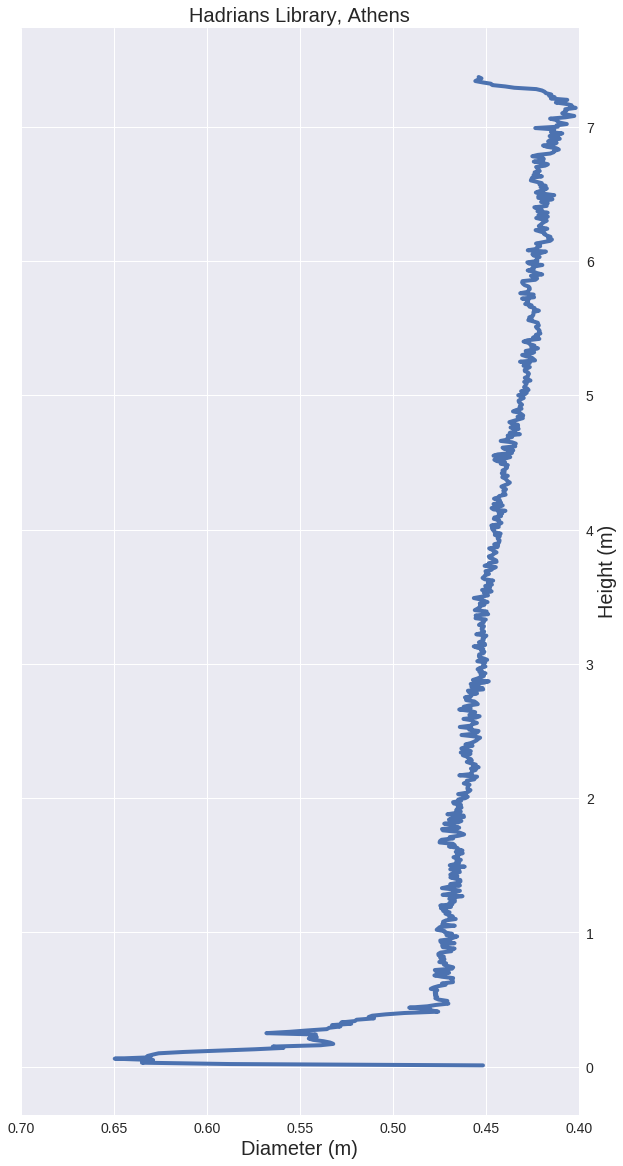

Head of table for file:  http://repository.edition-topoi.org/CLMN/ReposCLMN/CLMN00106/Cottanello.xyz
          0         1         2
0  0.367698 -0.450901  7.569103
1  0.988948 -1.321222  6.507797
2  0.283153 -1.187461  3.074759
3  0.323406 -0.310063  0.152878
4  0.940983 -1.268904  9.067788


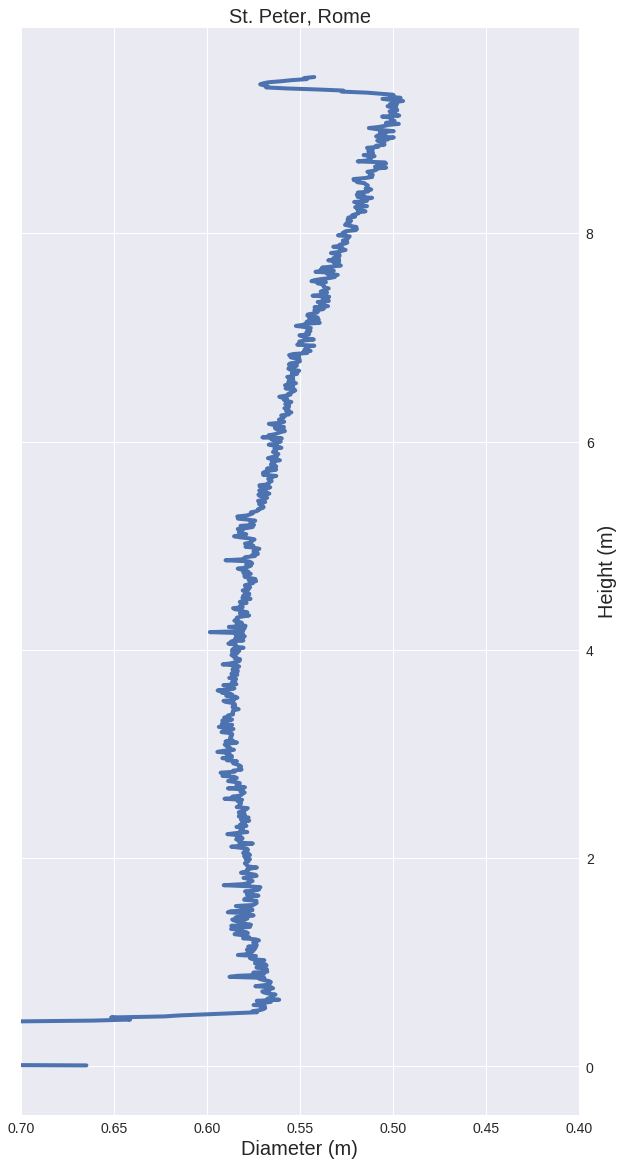

In [7]:
X=[p for p in np.arange(slice_range,15,slice_range)]

df_out = pd.DataFrame(index=X)

for file in file_list:
    df=pd.read_csv(file,sep=" ",header=None, index_col=None, usecols=[0,1,2])
    print('Head of table for file:  {0}'.format(file))
    print(df.head())
    df.columns = ["X", "Y", "Z"]
    df = df.sort_values(by="Z", ascending=[1])
    max_height = float(df['Z'].max())
    
    plot_list=[]  
    for i in np.arange(slice_range,max_height,slice_range):
        j=i-slice_range
        data=df.loc[df['Z'].between(j,i)]
        n=list(zip(data["X"],data["Y"]))
        if len(n)>0:
            u=[[i[0],i[1]] for i in n]
            m=make_circle(u)
            plot_list.append((i,m[2]))
        else:
            plot_list.append((i,nan))
        #else:
        #    plot_list.append((i,max(maxi)))
        #print(max(maxi),alge_diameter(list(data["X"])-center_avg[0],list(data["Y"])-center_avg[0]))
        x2,y2=[],[]
        for i in plot_list:
            x2.append(i[1])
            y2.append(i[0])

    fig = plt.figure(figsize=(10,20))
    
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

    ax = fig.add_subplot(111)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    plt.ylabel('Height (m)', fontsize=20)

    plt.plot(x2,y2, linewidth=4.0)
    plt.xlim(xmax, xmin)
    plt.title(plot_name[file_list.index(file)], fontsize=20)
    plt.xlabel('Diameter (m)', fontsize=20)

    if save_plot == True:
        plt.savefig(plot_name[file_list.index(file)]+'-2.png')

    plt.show()


    x2+=[nan for p in range(len(X)-len(x2))]

    df_out[plot_name[file_list.index(file)]]=pd.Series(x2,index=X)
df_out = df_out.dropna(axis=0,how='all')

# Multiplot

In case multiple columns are processed at the same time, the plot shows the entasis of all columns in one plot.

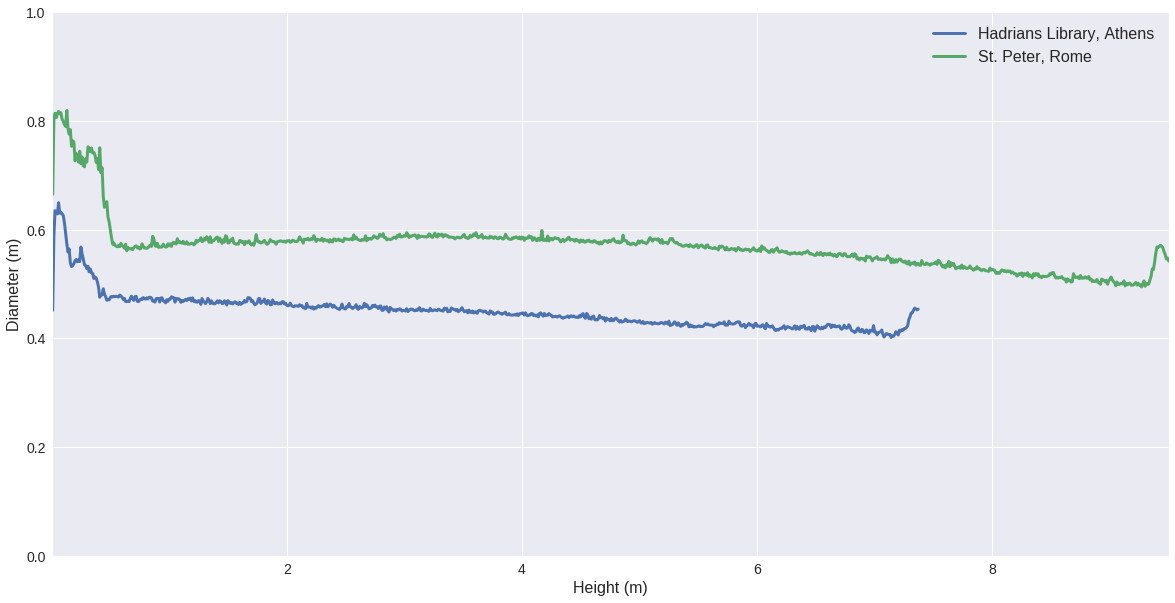

In [8]:
ax = df_out.plot(figsize=(20,10), ylim=(0,1), linewidth=3.0)
ax.legend(fontsize=16)
ax.set_xlabel("Height (m)", fontsize=16)
ax.set_ylabel("Diameter (m)", fontsize=16)

if save_plot == True:
        plt.savefig('MultiColumnPlot.png')

plt.show()

# Default plot

Changed xmax- and xmin-values of the xaxis while importing the data is shown in the plots above. Every entasis is additionally plotted with x-axis values from 0 to 1 and the y-axis as maximum value of the highest column. 

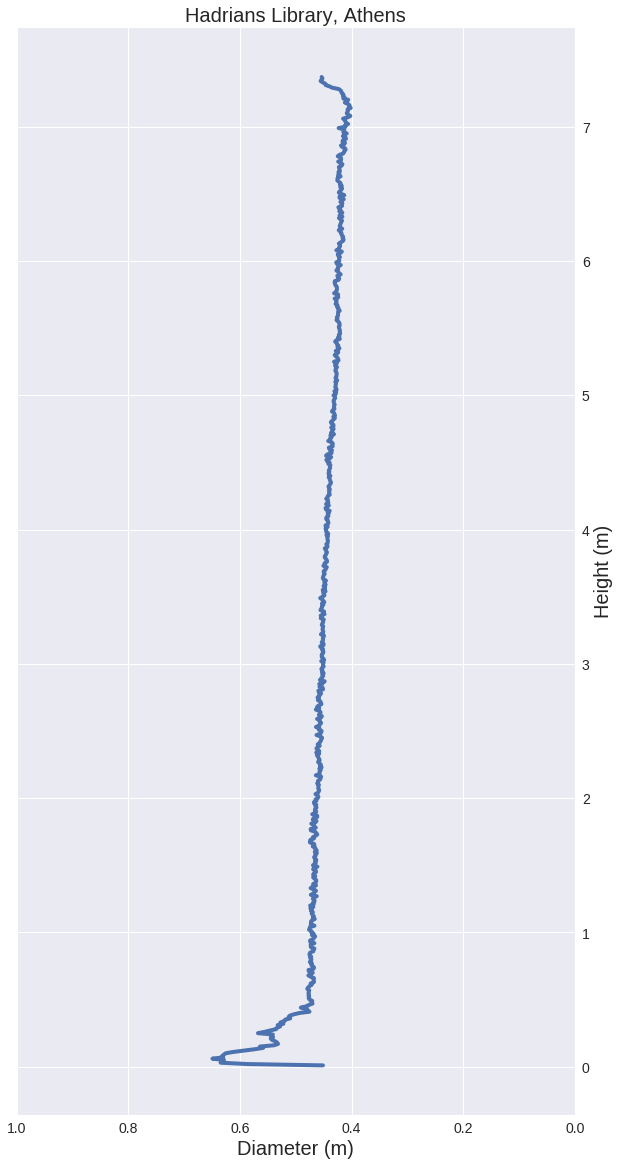

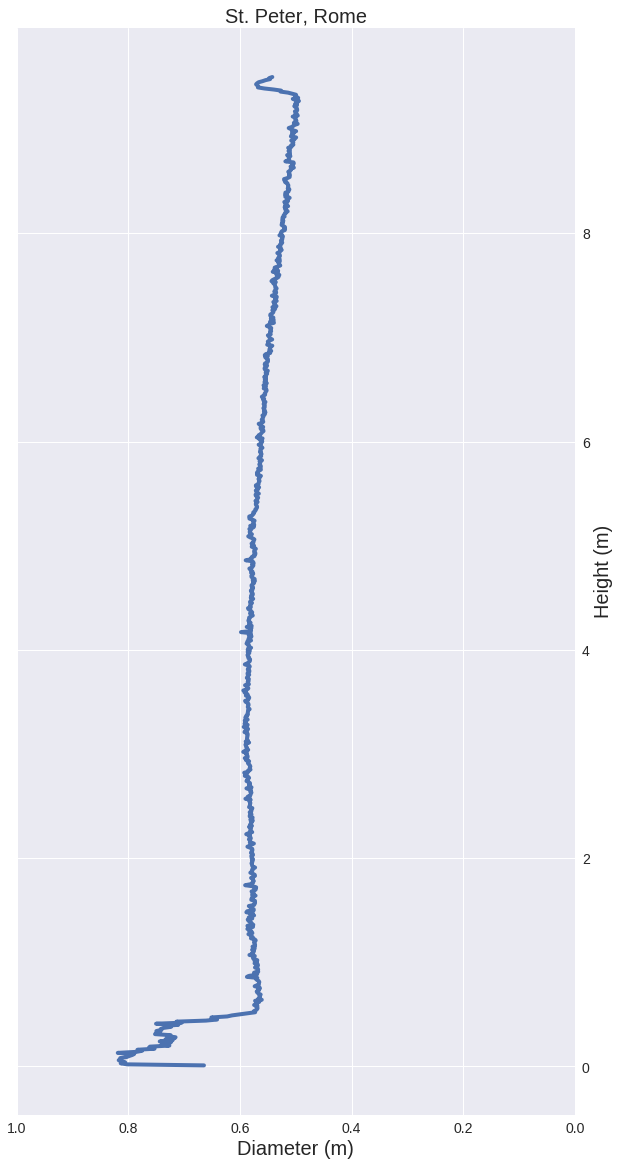

In [9]:
for plot in plot_name:
#    df_out[plot].plot(figsize=(20,10), ylim=(0,1))
        fig = plt.figure(figsize=(10,20))
    
        plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

        ax = fig.add_subplot(111)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        plt.ylabel('Height (m)', fontsize=20)

        x2 = df_out[plot].index.values
        y2 = df_out[plot].values

        plt.plot(y2,x2, linewidth=4.0)
        plt.xlim(1, 0)
        plt.title(plot, fontsize=20)
        plt.xlabel('Diameter (m)', fontsize=20)
        if save_plot == True:
            plt.savefig(plot+'.png')
        plt.show()